The goal of this notebook is to remove multicollinearity in our dataset programmatically. We want to take in a dataset, identify pairs of highly correlated predictor (independent) variables (corr. above .7), and remove the predictor variable with the higher variance within the pair.

## 1. Importing Data, Subsetting and Removing IDs

In [2]:
import pandas as pd
import numpy as np
from dython.nominal import associations

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
gdrive_url = 'https://drive.google.com/file/d/1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF/view?usp=drive_link'

file_id = '1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url, encoding='utf-8')
df.head()

,game_id,season,team_id,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,...,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
0,40400407,2004-05,1610612759,Spurs,SAS,spurs,240:00,29.0,68.0,0.426,...,0.0,0.426,0.0,0.0,0.0,74.0,1,1,1,0
1,40400406,2004-05,1610612759,Spurs,SAS,spurs,240:00,31.0,75.0,0.413,...,0.0,0.413,0.0,0.0,0.0,95.0,1,0,1,0
2,40400405,2004-05,1610612765,Pistons,DET,pistons,265:00,37.0,84.0,0.440,...,0.0,0.440,0.0,0.0,0.0,96.0,1,0,1,0
3,40400404,2004-05,1610612765,Pistons,DET,pistons,240:00,41.0,90.0,0.456,...,0.0,0.456,0.0,0.0,0.0,71.0,1,1,1,0
4,40400403,2004-05,1610612765,Pistons,DET,pistons,240:00,40.0,85.0,0.471,...,0.0,0.471,0.0,0.0,0.0,79.0,1,1,1,0


Now we will filter for game data after 2014 (this is to reduce missing data errors that exist before 2014)

In [4]:
print(f'Dropping Seasons:\n  Seasons before Dropping: {df.season.unique()}') 
df = df[df['season'].str[:4].astype(int) > 2013] # Remove old seasons (this was causing issues)
print(f'  The seasons are now: {df.season.unique()}\n') 

Dropping Seasons:
  Seasons before Dropping: ['2004-05' '2005-06' '2006-07' '2007-08' '2008-09' '2009-10' '2010-11'
 '2011-12' '2012-13' '2013-14' '2014-15' '2015-16' '2016-17' '2017-18'
 '2018-19' '2019-20' '2020-21' '2021-22' '2022-23' '2023-24']
  The seasons are now: ['2014-15' '2015-16' '2016-17' '2017-18' '2018-19' '2019-20' '2020-21'
 '2021-22' '2022-23' '2023-24']



Then, filter the dataset for only numeric data (we want to remove unnecessary categorical data that should not be turned into dummy variables)

In [5]:
df_numeric = df.select_dtypes('number') # Filter for only numbers

to_drop = ['game_id','team_id', 'is_home_team'] # Drop IDs
df_dropped_ids = df_numeric.drop(to_drop, axis=1)

df_dropped_ids.head()

,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,free_throws_percentage,rebounds_offensive,...,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,won_game,is_playoff_game,is_regular_game
13932,32.0,82.0,0.390,6.0,26.0,0.231,27.0,39.0,0.692,16.0,...,38.0,0.316,0.390,17.0,28.0,0.607,105.0,0,1,0
13933,36.0,75.0,0.480,12.0,26.0,0.462,20.0,34.0,0.588,11.0,...,42.0,0.548,0.480,11.0,22.0,0.500,91.0,1,1,0
13934,29.0,88.0,0.330,4.0,27.0,0.148,20.0,28.0,0.714,16.0,...,42.0,0.238,0.330,9.0,14.0,0.643,103.0,0,1,0
13935,35.0,76.0,0.461,9.0,21.0,0.429,17.0,24.0,0.708,6.0,...,30.0,0.467,0.461,12.0,24.0,0.500,91.0,1,1,0
13936,33.0,83.0,0.398,8.0,35.0,0.229,19.0,25.0,0.760,10.0,...,47.0,0.404,0.398,7.0,19.0,0.368,95.0,0,1,0


In [6]:
df_dropped_ids.dropna()

,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,free_throws_percentage,rebounds_offensive,...,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,won_game,is_playoff_game,is_regular_game
13932,32.0,82.0,0.390,6.0,26.0,0.231,27.0,39.0,0.692,16.0,...,38.0,0.316,0.390,17.0,28.0,0.607,105.0,0,1,0
13933,36.0,75.0,0.480,12.0,26.0,0.462,20.0,34.0,0.588,11.0,...,42.0,0.548,0.480,11.0,22.0,0.500,91.0,1,1,0
13934,29.0,88.0,0.330,4.0,27.0,0.148,20.0,28.0,0.714,16.0,...,42.0,0.238,0.330,9.0,14.0,0.643,103.0,0,1,0
13935,35.0,76.0,0.461,9.0,21.0,0.429,17.0,24.0,0.708,6.0,...,30.0,0.467,0.461,12.0,24.0,0.500,91.0,1,1,0
13936,33.0,83.0,0.398,8.0,35.0,0.229,19.0,25.0,0.760,10.0,...,47.0,0.404,0.398,7.0,19.0,0.368,95.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55309,45.0,112.0,0.402,13.0,53.0,0.245,19.0,24.0,0.792,16.0,...,0.0,0.000,0.402,0.0,0.0,0.000,127.0,0,0,0
55310,42.0,95.0,0.442,14.0,37.0,0.378,32.0,38.0,0.842,11.0,...,0.0,0.000,0.442,0.0,0.0,0.000,126.0,1,0,0
55311,39.0,90.0,0.433,14.0,31.0,0.452,12.0,16.0,0.750,13.0,...,0.0,0.000,0.433,0.0,0.0,0.000,96.0,1,0,0
55312,34.0,85.0,0.400,12.0,32.0,0.375,9.0,17.0,0.529,9.0,...,0.0,0.000,0.410,0.0,0.0,0.000,103.0,0,0,0


We can confirm that each process above ran correctly with the following code.

We should see a minimum season of 2014-15 in the original dataframe, a dataset of only float64 and int64 types in `df_dropped_ids`, and no ID variables in `df_dropped_ids`.

In [7]:
print(f'Oldest Season in the Dataset: {df.season.min()}') # Check if seasons are correct
print(f'The dataset is made up of the types: {set(df_dropped_ids.dtypes)}') # Check if types are correct
id_cols = [col for col in df_dropped_ids.columns if 'id' in col]
print(f'The following ID columns still exist in the dataset (if [], removal succeeded): {id_cols}') # Check if ID cols exist

Oldest Season in the Dataset: 2014-15
The dataset is made up of the types: {dtype('int64'), dtype('float64')}
The following ID columns still exist in the dataset (if [], removal succeeded): []


Now that we have a cleaned dataset, we can begin to clean the Multicollinear Elements. Let's separate the predictor (independent) and response (dependent) variables and then take care of the highly correlated predictors.

In [8]:
y = df_dropped_ids['points']
X = df_dropped_ids.drop(columns=['points'], axis=1)

In [9]:
y

13932     97.0
13933    104.0
13934     82.0
13935     96.0
13936     93.0
         ...  
55309    122.0
55310    130.0
55311    104.0
55312     89.0
55313     99.0
Name: points, Length: 27450, dtype: float64

In [10]:
X.head(10)

,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,free_throws_percentage,rebounds_offensive,...,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,won_game,is_playoff_game,is_regular_game
13932,32.0,82.0,0.390,6.0,26.0,0.231,27.0,39.0,0.692,16.0,...,38.0,0.316,0.390,17.0,28.0,0.607,105.0,0,1,0
13933,36.0,75.0,0.480,12.0,26.0,0.462,20.0,34.0,0.588,11.0,...,42.0,0.548,0.480,11.0,22.0,0.500,91.0,1,1,0
13934,29.0,88.0,0.330,4.0,27.0,0.148,20.0,28.0,0.714,16.0,...,42.0,0.238,0.330,9.0,14.0,0.643,103.0,0,1,0
13935,35.0,76.0,0.461,9.0,21.0,0.429,17.0,24.0,0.708,6.0,...,30.0,0.467,0.461,12.0,24.0,0.500,91.0,1,1,0
13936,33.0,83.0,0.398,8.0,35.0,0.229,19.0,25.0,0.760,10.0,...,47.0,0.404,0.398,7.0,19.0,0.368,95.0,0,1,0
13937,39.0,88.0,0.443,10.0,27.0,0.370,20.0,22.0,0.909,11.0,...,51.0,0.549,0.443,12.0,18.0,0.667,100.0,1,1,0
13938,37.0,91.0,0.407,9.0,29.0,0.310,21.0,31.0,0.677,19.0,...,57.0,0.421,0.407,17.0,28.0,0.607,90.0,1,1,0
13939,43.0,87.0,0.494,13.0,31.0,0.419,19.0,30.0,0.633,13.0,...,46.0,0.500,0.494,21.0,28.0,0.750,88.0,1,1,0
13940,43.0,76.0,0.566,17.0,32.0,0.531,25.0,43.0,0.581,4.0,...,38.0,0.579,0.566,16.0,24.0,0.667,115.0,1,1,0
13941,40.0,97.0,0.412,14.0,36.0,0.389,20.0,29.0,0.690,19.0,...,57.0,0.386,0.412,11.0,20.0,0.550,111.0,1,1,0


We will take the predictor variables `X` and examine their correlations in the following function. This function takes in a DataFrame of independent variables and a threshold. This threshold is the correlation level where if a pair of predictors has a correlation > threshold, we remove one of the features. The feature we remove is the one with the higher variance. This function should return a tuple made up of the resultant (cleaned) dataframe, and a table containing the dropped feature names, their variance, and which feature had a lower variance than it, resulting in the drop.


In [13]:
'''
This function drops highly correlated variables given a threshold.
It drops the variable with smaller variance.

It returns:
1. The variables that were dropped
2. The data without the dropped variables
'''

def drop_highly_correlated(data, threshold=.7):
    from dython.nominal import associations
    cor_matrix = associations(dataset=data, compute_only=True)['corr'].abs()
    #cor_matrix = data.corr().abs()
    sol = (cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))).unstack().dropna()

    to_drop=[]
    for i in range(len(sol[sol > threshold].index.tolist())):
        var1 = sol[sol >= threshold].index.tolist()[i][0]
        var2 = sol[sol >= threshold].index.tolist()[i][1]

        if(data[var1].var() < data[var2].var()): 
            to_drop.append(var1)
        else: 
            to_drop.append(var2)

    dropped_vars = list(set(to_drop))
    return dropped_vars, data.drop(dropped_vars, axis=1)

In [17]:
res = drop_highly_correlated(X)

X_cleaned = res[1]
dropped_features = res[0]

In [18]:
X_cleaned.head()

,field_goals_attempted,three_pointers_attempted,three_pointers_percentage,free_throws_attempted,free_throws_percentage,rebounds_offensive,rebounds_total,steals,blocks,turnovers,...,estimated_usage_percentage,pace,possessions,touches,secondary_assists,free_throw_assists,assists,opponent_points,is_playoff_game,is_regular_game
13932,82.0,26.0,0.231,39.0,0.692,16.0,56.0,3.0,7.0,16.0,...,0.198,100.00,100.0,372.0,2.0,1.0,14.0,105.0,1,0
13933,75.0,26.0,0.462,34.0,0.588,11.0,43.0,7.0,2.0,16.0,...,0.196,89.50,89.0,397.0,4.0,1.0,25.0,91.0,1,0
13934,88.0,27.0,0.148,28.0,0.714,16.0,49.0,2.0,3.0,9.0,...,0.203,91.00,91.0,411.0,4.0,2.0,16.0,103.0,1,0
13935,76.0,21.0,0.429,24.0,0.708,6.0,43.0,9.0,8.0,14.0,...,0.197,92.50,92.0,334.0,1.0,0.0,15.0,91.0,1,0
13936,83.0,35.0,0.229,25.0,0.760,10.0,45.0,11.0,7.0,18.0,...,0.198,94.19,104.0,412.0,0.0,5.0,16.0,95.0,1,0


In [19]:
dropped_features

['effective_field_goal_percentage',
 'defended_at_rim_field_goals_made',
 'pace_per40',
 'assist_ratio',
 'won_game',
 'uncontested_field_goals_percentage',
 'rebound_chances_defensive',
 'defended_at_rim_field_goals_attempted',
 'assist_percentage',
 'true_shooting_percentage',
 'passes',
 'usage_percentage',
 'plus_minus_points',
 'field_goal_percentage',
 'field_goals_made',
 'rebounds_defensive',
 'three_pointers_made',
 'rebound_percentage',
 'rebound_chances_total',
 'contested_field_goals_attempted',
 'distance',
 'defended_at_rim_field_goal_percentage',
 'field_goals_percentage',
 'turnover_ratio',
 'estimated_defensive_rating',
 'estimated_pace',
 'uncontested_field_goals_attempted',
 'contested_field_goal_percentage',
 'estimated_team_turnover_percentage',
 'rebound_chances_offensive',
 'p_i_e',
 'uncontested_field_goals_made',
 'contested_field_goals_made',
 'net_rating',
 'defensive_rating',
 'free_throws_made',
 'assist_to_turnover',
 'estimated_offensive_rating']

Now that we have a (hopefully) cleaned dataset, we can examine the correlation heatmap of the cleaned data to make sure no multicollinearity still exists in the data.

In [20]:
# Adding y back to the independent vars X
df_combined = pd.concat([y,X_cleaned], axis=1)
df_combined.head()

,points,field_goals_attempted,three_pointers_attempted,three_pointers_percentage,free_throws_attempted,free_throws_percentage,rebounds_offensive,rebounds_total,steals,blocks,...,estimated_usage_percentage,pace,possessions,touches,secondary_assists,free_throw_assists,assists,opponent_points,is_playoff_game,is_regular_game
13932,97.0,82.0,26.0,0.231,39.0,0.692,16.0,56.0,3.0,7.0,...,0.198,100.00,100.0,372.0,2.0,1.0,14.0,105.0,1,0
13933,104.0,75.0,26.0,0.462,34.0,0.588,11.0,43.0,7.0,2.0,...,0.196,89.50,89.0,397.0,4.0,1.0,25.0,91.0,1,0
13934,82.0,88.0,27.0,0.148,28.0,0.714,16.0,49.0,2.0,3.0,...,0.203,91.00,91.0,411.0,4.0,2.0,16.0,103.0,1,0
13935,96.0,76.0,21.0,0.429,24.0,0.708,6.0,43.0,9.0,8.0,...,0.197,92.50,92.0,334.0,1.0,0.0,15.0,91.0,1,0
13936,93.0,83.0,35.0,0.229,25.0,0.760,10.0,45.0,11.0,7.0,...,0.198,94.19,104.0,412.0,0.0,5.0,16.0,95.0,1,0


In [21]:
def my_corrplot(df, dep_var):
    import seaborn as sns
    from dython.nominal import associations

    # create a correlation matrix of all predictor variables using 'associations'
    corr_matrix = associations(dataset=df.drop(dep_var, axis=1), compute_only=True)['corr']

    # Mask upper triangle of the corr heatmap ???
    mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Plot
    plt.figure(figsize=(44,44))
    sns.heatmap(corr_matrix, annot=True, mask=mask_upper, fmt='.2f', vmin=-1, vmax=1)
    plt.show()

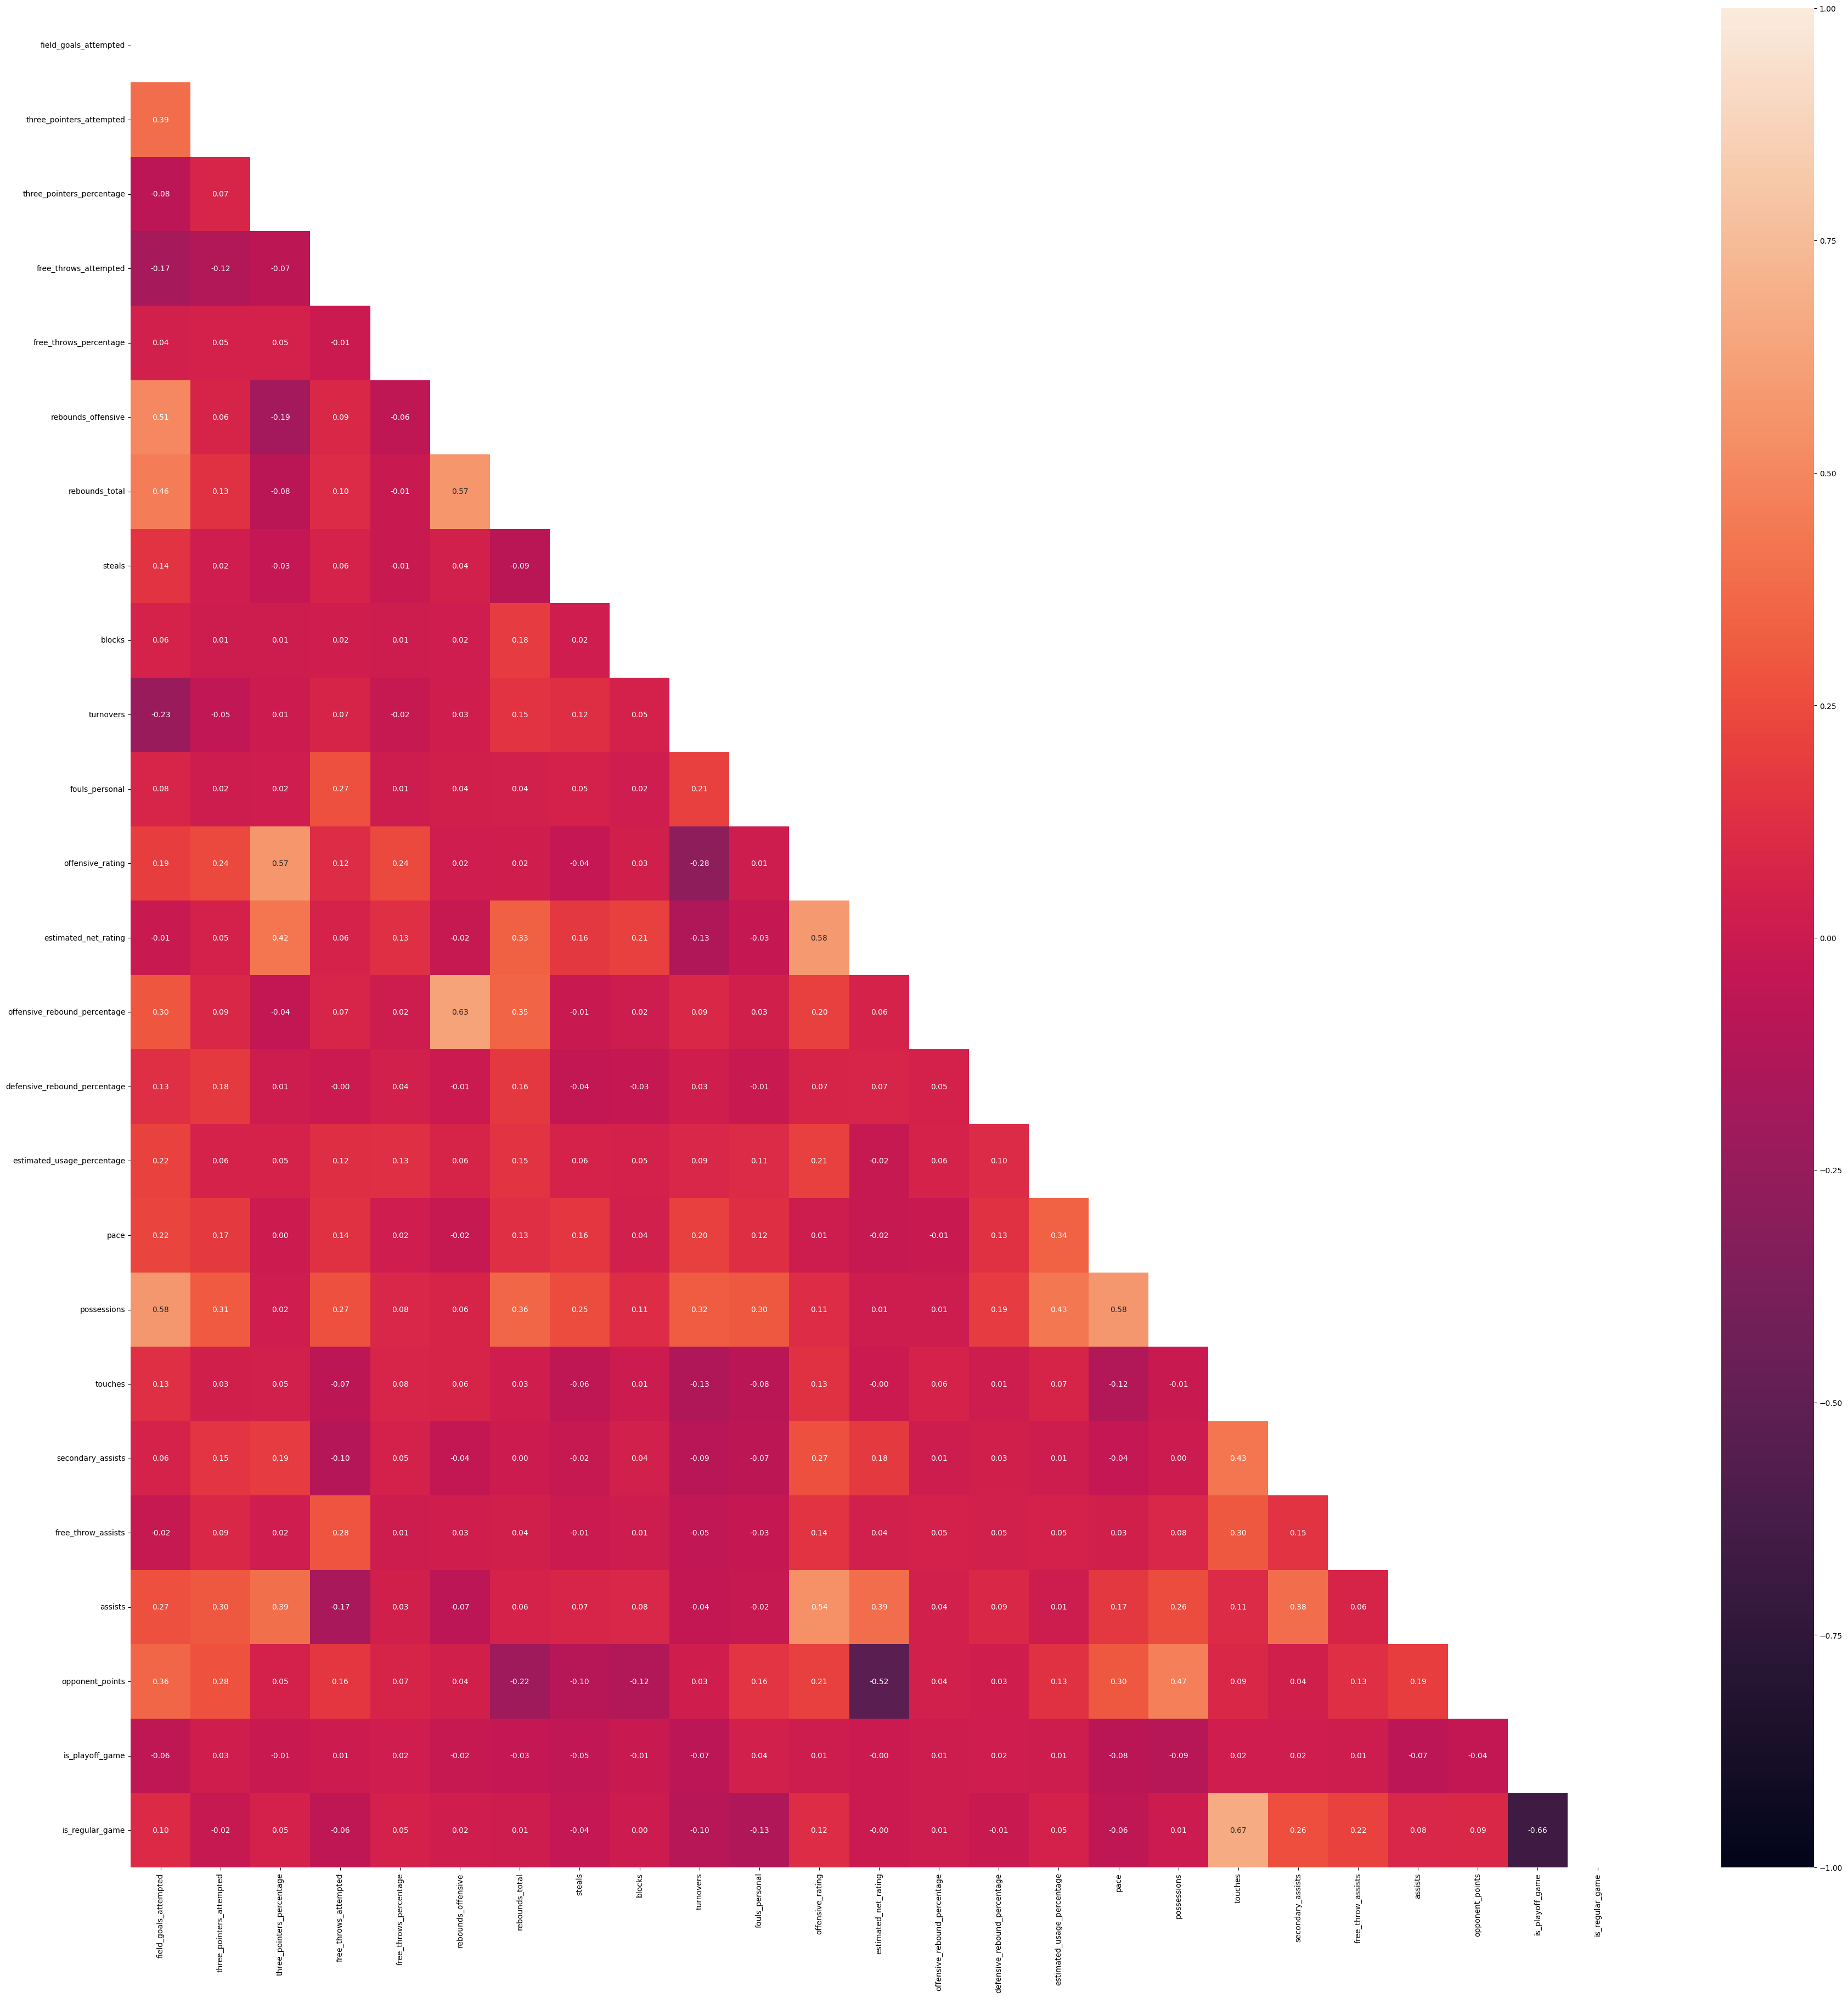

In [22]:
my_corrplot(df_combined, 'points')